# Quantitative Structure-Activity Relationship of Fish Toxicity

This project aims to analyze the quantitative structure-activity relationship to predict acute aquatic toxicity towards the fish Pimephales promelas (fathead minnow) on a set of 908 chemicals. The method used are the Multiple Linear Regression (MLR) and the k-Nearest Neighbor (KNN).

***
Variables used are:

* CIC0
* SM1_Dz(Z)
* GATS1i
* NdsCH
* NdssC
* MLOGP
* Target variables, LC50 \[-LOG(mol/L)]

***

Dataset source : https://archive.ics.uci.edu/ml/datasets/QSAR+fish+toxicity

Import libraries

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
plt.style.use('fivethirtyeight')

Load the dataset

In [53]:
dataset = pd.read_csv('dataset/qsar_fish_toxicity.csv')
dataset.head(10)

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50 [-LOG(mol/L)]
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390
5,3.222,0.331,2.177,0,0,0.706,1.819
6,3.179,0.000,1.063,0,0,2.942,3.947
7,3.000,0.000,0.938,1,0,2.851,3.513
8,2.620,0.499,0.990,0,0,2.942,4.402
9,2.834,0.134,0.950,0,0,1.591,3.021


Generate descriptive statistics of the dataset

In [54]:
dataset.describe()

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50 [-LOG(mol/L)]
count,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000
mean,2.898129,0.628468,1.293591,0.229075,0.485683,2.109285,4.064431
std,0.756088,0.428459,0.394303,0.605335,0.861279,1.433181,1.455698
min,0.667000,0.000000,0.396000,0.000000,0.000000,-2.884000,0.053000
25%,2.347000,0.223000,0.950750,0.000000,0.000000,1.209000,3.151750
50%,2.934000,0.570000,1.240500,0.000000,0.000000,2.127000,3.987500
75%,3.407000,0.892750,1.562250,0.000000,1.000000,3.105000,4.907500
max,5.926000,2.171000,2.920000,4.000000,6.000000,6.515000,9.612000


Calculate the correlation of each columns with the LC50

In [67]:
dataset.corr(method='pearson')

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50 [-LOG(mol/L)]
CIC0,1.000000,-0.235360,0.147622,0.121341,0.246639,0.463867,0.291854
SM1_Dz(Z),-0.235360,1.000000,-0.145967,-0.141401,0.163179,0.200663,0.410893
GATS1i,0.147622,-0.145967,1.000000,-0.010657,0.092410,-0.450739,-0.397965
NdsCH,0.121341,-0.141401,-0.010657,1.000000,0.188164,0.048620,0.172004
NdssC,0.246639,0.163179,0.092410,0.188164,1.000000,0.028499,0.172390
MLOGP,0.463867,0.200663,-0.450739,0.048620,0.028499,1.000000,0.651664
LC50 [-LOG(mol/L)],0.291854,0.410893,-0.397965,0.172004,0.172390,0.651664,1.000000


From the correlation test to the LC50 that has been done above, it is known that MLOGP has the highest correlation of 0.652 and GATS1i has the lowest correlation of -0.398.

Split the dependent and independent variables in the dataset

In [56]:
x = dataset.iloc[:, :6]
y = dataset.iloc[:, 6:]

Scales the independent variables

In [57]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

Split the dataset into training and testing set

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

Select the best k value for the KNN model

In [71]:
knn_result = []

for k in range (2, 10):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train, y_train)
    knn_result.append(knn.score(x_train, y_train))
    print('R-Squared for k = {} : {}'.format(k, knn.score(x_train, y_train)))

R-Squared for k = 2 : 0.8653764816143904
R-Squared for k = 3 : 0.7954135204488817
R-Squared for k = 4 : 0.7624969315024511
R-Squared for k = 5 : 0.7504137145813292
R-Squared for k = 6 : 0.7402369618152194
R-Squared for k = 7 : 0.7234686607718196
R-Squared for k = 8 : 0.7113630755584535
R-Squared for k = 9 : 0.7042351209450803


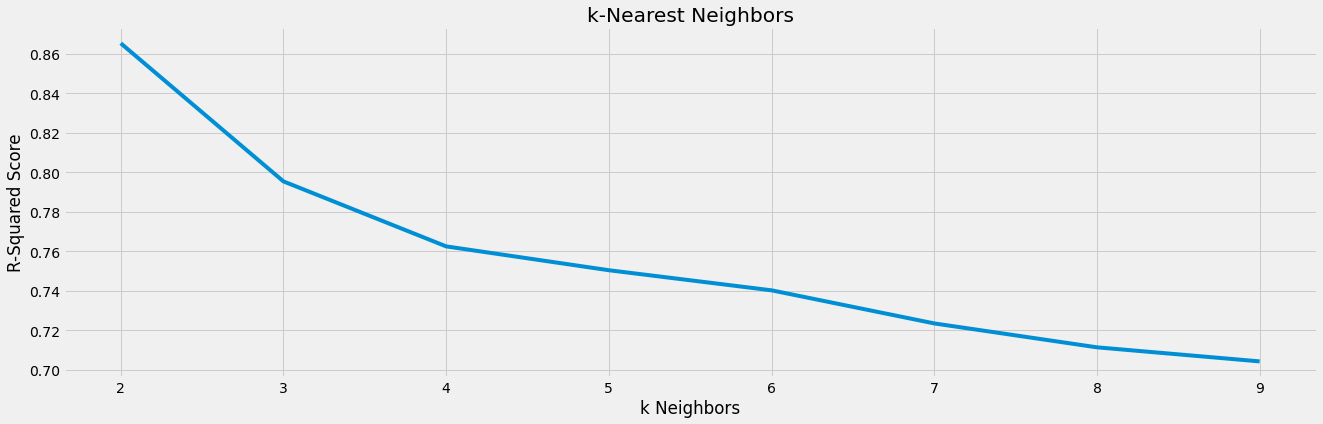

In [73]:
plt.figure(figsize=(20,6))
plt.plot([i for i in range(2, 10)], knn_result)
plt.xlabel('k Neighbors')
plt.ylabel('R-Squared Score')
plt.title('k-Nearest Neighbors')
plt.show()

It can be seen that the R-Squared value decreases with the increase of k used. The best R-Squared is obtained at the k=2, which will then be used to make the KNN model.

Create a KNN model and evaluate the model on the training set

In [81]:
knn = KNeighborsRegressor(n_neighbors=2).fit(x_train,y_train)
knn_training_pred = knn.predict(x_train)
knn_training_rsq = knn.score(x_train,y_train)
knn_training_rmse = np.sqrt(mean_squared_error(y_train, knn_training_pred))

print('R-Squared for the training set :', knn_training_rsq)
print('RMSE for the training set :', knn_training_rmse)

R-Squared for the training set : 0.8653764816143904
RMSE for the training set : 0.5241587796732398


Evaluate the model on the testing set

In [82]:
knn_testing_pred = knn.predict(x_test)
knn_testing_rsq = knn.score(x_test,y_test)
knn_testing_rmse = np.sqrt(mean_squared_error(y_test, knn_testing_pred))

print('R-Squared for the testing set :', knn_testing_rsq)
print('RMSE for the testing set :', knn_testing_rmse)

R-Squared for the testing set : 0.528131511437169
RMSE for the testing set : 1.068491680432677


Visualize the regression plot and the residual plot of the KNN method

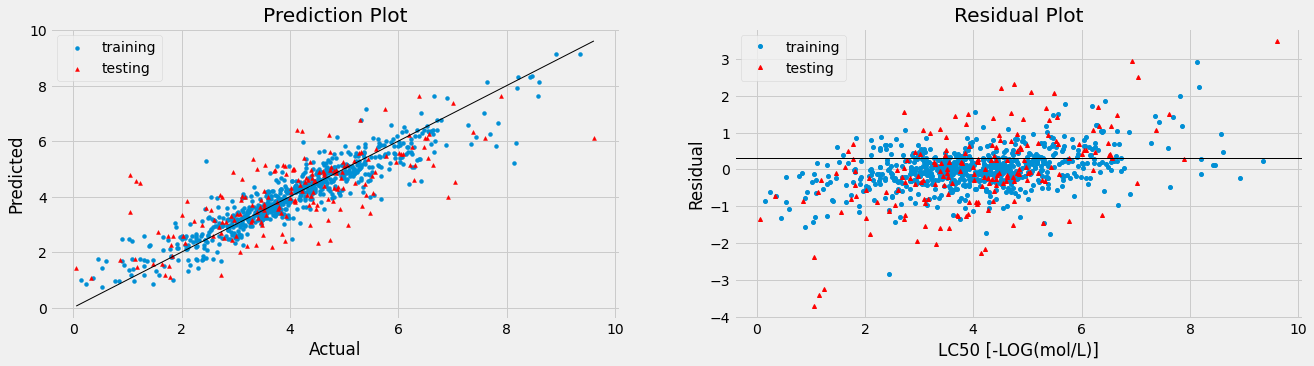

In [87]:
residual_train = y_train - knn_training_pred
residual_test = y_test - knn_testing_pred

fig=plt.figure(figsize=(20,5))

ax1=plt.subplot(1,2,1)
ax1.scatter(y_train, knn_training_pred, s=15, label='training')
ax1.scatter(y_test, knn_testing_pred, marker='^', s=15, c='r', label='testing')
ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'k', lw=1)
ax1.set_title('Prediction Plot')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.legend()

ax2=plt.subplot(1,2,2)
ax2.plot(y_train, residual_train, 'o', markersize= 4, label='training')
ax2.plot(y_test, residual_test, '^', c='red', markersize= 4, label='testing')
ax2.axhline(y=0.3, linewidth= 1, linestyle='-', c='black')
ax2.legend()
ax2.set_title('Residual Plot')
ax2.set_xlabel('LC50 [-LOG(mol/L)]')
ax2.set_ylabel('Residual')

plt.show()

### Conclusion

The KNN model to predict acute aquatic toxicity towards the fish Pimephales promelas (fathead minnow) has been successfully developed. In the parameter tuning process, the best k is 2. Based on the model evaluation results, it is known that the model has succeeded in obtaining good R-Squared and RMSE values in the training set, but the results obtained in the testing set are not good enough.

Save the model

In [84]:
filename = 'dataset/qsar_fish_toxicity_model.sav'
pickle.dump(knn, open(filename, 'wb'))